In [3]:
import os
import gzip
import shutil
import json
import pandas as pd
import _pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

## Data Preprocessing for entries
Aggregation according to each person(only run once, save results in pickles) 

In [2]:
df_file = pd.DataFrame()

In [88]:
def transfer_dataframe(patient_id, file_name):
    with open(file_name) as file:
        j_object = json.load(file)
        df = pd.DataFrame(j_object)
#         print(df.describe())
#         try:
#             df['datetime'] = pd.Timestamp(df['dateString']).to_datetime()
        df['datetime'] = pd.to_datetime(df['dateString'], utc=True)
#         except ValueError:
# #             df['datetime'] = pd.to_datetime(df['dateString'],format="%d/%m/%Y %H:%M:%S %p")
#         else:
#             raise        
        df['pid'] = patient_id
        df_result = df[['pid', 'datetime', 'sgv']]
        df_result = df_result.sort_values(by=['datetime'], ascending = True)
    return df_result

In [ ]:
count = 0
path = '/home/jupyter/work/openaps/data'
for folder in os.listdir(path):
    print('PID:', folder)
    record_path = path + '/' +folder+'/direct-sharing-31'
    if os.path.exists(record_path):
        files = os.listdir(record_path)
        df_folder = pd.DataFrame([], columns=['pid', 'datetime', 'sgv'])
        for file in files:
            if file.find('entries') > -1 and file.endswith('.json'):
                print('file', file)
                try:
                    df = transfer_dataframe(folder, record_path+'/'+file)
                except :
                    print(folder, file, 'cannot be transfered to datetime, pass' )
                    continue
                  
                df_folder = df_folder.append(df)
        print('before drop', len(df_folder))
        df_folder.drop_duplicates('datetime',inplace = True)
        print('after drop', len(df_folder))
        df_folder.sort_values(by = 'datetime', ascending = True, inplace = True)
        print('saving result...')
        pickle.dump(df_folder, open(path + '/entry_dfs/'+folder+'_entries.pkl', 'wb'))
        print('done for', folder)
        print('----------------------')

        

In [ ]:
pd.to_datetime('2017-10-08T19:58:22.681-0400', utc=True)

In [5]:
len(os.listdir(os.getcwd()+'/OpenAPS/entry_dfs'))
    

110

In [ ]:
path = os.getcwd()+'/OpenAPS/entry_dfs'
for file in os.listdir(path):
    df = pickle.load(open(path+'/'+file, 'rb'))
    print(df.head())

## Data preprocessing -2
Find time intervals in same length(save results in pickles)

In [ ]:
count = 0
start_date = '2017-03-01'
end_date = '2017-03-11'
path = '/Users/wang/data/OpenAPS/entry_dfs_sliced'
for file in os.listdir(path):
    df = pickle.load(open(path+'/'+file, 'rb'))
#     mask = (df['datetime'] > '2017-03-01') & (df['datetime'] < '2017-03-11')
    df.set_index('datetime',inplace = True)
#     df.index = df.tz_convert('America/Los_Angeles')
    df = df.tz_convert(None)

    df_selected = df[start_date:end_date]
    if len(df_selected)>0:
        print(df_selected.index[:2])
        print(df_selected['pid'].values[0])
        pickle.dump(df_selected, open(os.getcwd()+'/OpenAPS/entry_dfs_sliced/'+df_selected['pid'].values[0]+'.pkl', 'wb'))
        count += 1
print('Instances found:', count)        

## Compute distance with Dynamic Time Wrappinng

In [51]:
import math
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            
    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

In [136]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
#         print('i', i)
#         print('upper_bound', upper_bound)
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

In [ ]:
path2 = '/Users/wang/data/OpenAPS/entry_dfs_sliced/'

files = os.listdir(path2)

df1 = pickle.load(open(path2+'/'+files[0], 'rb'))
df2 = pickle.load(open(path2+'/'+files[1], 'rb'))

In [70]:
len(df1['sgv'].unique())

152

In [67]:
DTWDistance(df1['sgv'].values[:288], df2['sgv'].values[:288], 96)

365.276607518193

In [71]:
LB_Keogh(df1['sgv'].values[:288], df2['sgv'].values[:288], 96)

91.03296106356203

## Clustering with KNN

In [82]:
## load raw data
def load_data(path):
    rst = {}
    for file in os.listdir(path):
        df = pickle.load(open(path+'/'+file, 'rb'))
#         df.set_index('datetime',inplace = True)
#         df = df.tz_convert(None)
        df.dropna(inplace=True)
        if len(df)==0:
            continue
        pid =np.asscalar(df['pid'].values[:1])
    #     print('pid', pid)
        bgs = df.sgv.values[:288]
    #     print('len of bgs', len(bgs))
        if len(bgs)>0:
            rst[int(pid)] = bgs
        return rst


In [146]:
import random

def k_means_clust(bg_dicts,num_clust,num_iter,w=5):
    keys = list(bg_dicts.keys())
    # for the final result backtracking
    search_dict = {}
    for i in range(len(keys)):
        search_dict[i] = keys[i]
    data = list(bg_dicts.values())
    data = [[int(l) for l in r] for r in data]
    centroids = random.sample(data, num_clust)
       
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                lb = LB_Keogh(i,j,5)
                if lb<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind            
            assignments.setdefault(closest_clust,[])
            assignments[closest_clust].append(ind)
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(len(data[0]))
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids,assignments

In [ ]:
centroids, assignnments = k_means_clust(rst, 4, 10)

In [148]:
print(assignnments)

{3: [0, 5, 10, 14, 15, 16, 17, 19, 21, 25, 26, 29, 33, 36, 45, 48, 49, 53, 56, 57, 60, 62, 67, 68, 75, 76, 77], 0: [1, 18, 20, 30, 32, 35, 37, 39, 47, 50, 52, 58, 64, 65], 1: [2, 3, 6, 8, 11, 12, 23, 24, 27, 28, 31, 34, 38, 40, 41, 42, 43, 61, 66, 70, 71, 72, 78], 2: [4, 7, 9, 13, 22, 44, 46, 51, 54, 55, 59, 63, 69, 73, 74]}


In [154]:
keys = list(rst.keys())
clusters = {}
for k,v in assignnments.items():
    clusters[keys[k]] = [keys[i] for i in v]

for k,v in clusters.items():
    print(k,v)

57176789 [27700103, 84984656, 89710417, 897741, 28768536, 1884126, 1352464, 80373992, 89727223, 13029224, 66836068, 13484299, 32407882, 17161370, 7886752, 46966807, 98974339, 74077367, 14092221, 99296581, 62401782, 24587372, 45025419, 37948668, 39986716, 87770486, 88004055]
27700103 [96254963, 3572116, 67208817, 97417885, 67359234, 5274556, 47750728, 96484928, 60844515, 37764532, 85199788, 96805916, 21946407, 71397255]
96254963 [73521474, 57176789, 71236754, 49796612, 28176124, 40237051, 80501215, 24448124, 66019205, 95851255, 20216809, 84081904, 78420229, 77104076, 94875538, 41663654, 13783771, 95614431, 72492570, 99848889, 91161972, 38110191, 64024750]
73521474 [51336122, 43104037, 20396154, 79526193, 99908129, 37875431, 84589080, 43589707, 4762925, 34148224, 40997757, 84109428, 25692073, 15634563, 80796147]


## Hierachy Clustering

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [ ]:
# Preparing data
path = '/Users/wang/data/OpenAPS/entry_dfs_sliced'
window = 144
normal_data = np.zeros(144)
for file in os.listdir(path):
    df = pickle.load(open(path+'/'+file, 'rb'))
    pid =np.asscalar(df['pid'].values[:1])
    df.dropna(inplace=True)
    sgv_row = df['sgv'].values[:window]
    normal_data = np.concatenate([normal_data, sgv_row])


normal_data = normal_data.reshape((32,144))
normal_data = normal_data[1:]   
print(normal_data.shape)    
print(normal_data[0])


In [132]:
Z = linkage(normal_data, 'ward')

In [133]:
Z[:10]

array([[ 13.     ,  15.     , 157.42935,   2.     ],
       [ 17.     ,  19.     , 193.50969,   2.     ],
       [ 31.     ,  32.     , 228.18194,   4.     ],
       [  3.     ,  30.     , 270.14441,   2.     ],
       [ 10.     ,  11.     , 311.52207,   2.     ],
       [ 33.     ,  34.     , 325.97904,   6.     ],
       [  8.     ,  27.     , 349.72847,   2.     ],
       [ 21.     ,  35.     , 387.72069,   3.     ],
       [ 14.     ,  25.     , 399.9825 ,   2.     ],
       [  0.     ,  37.     , 417.45818,   3.     ]])

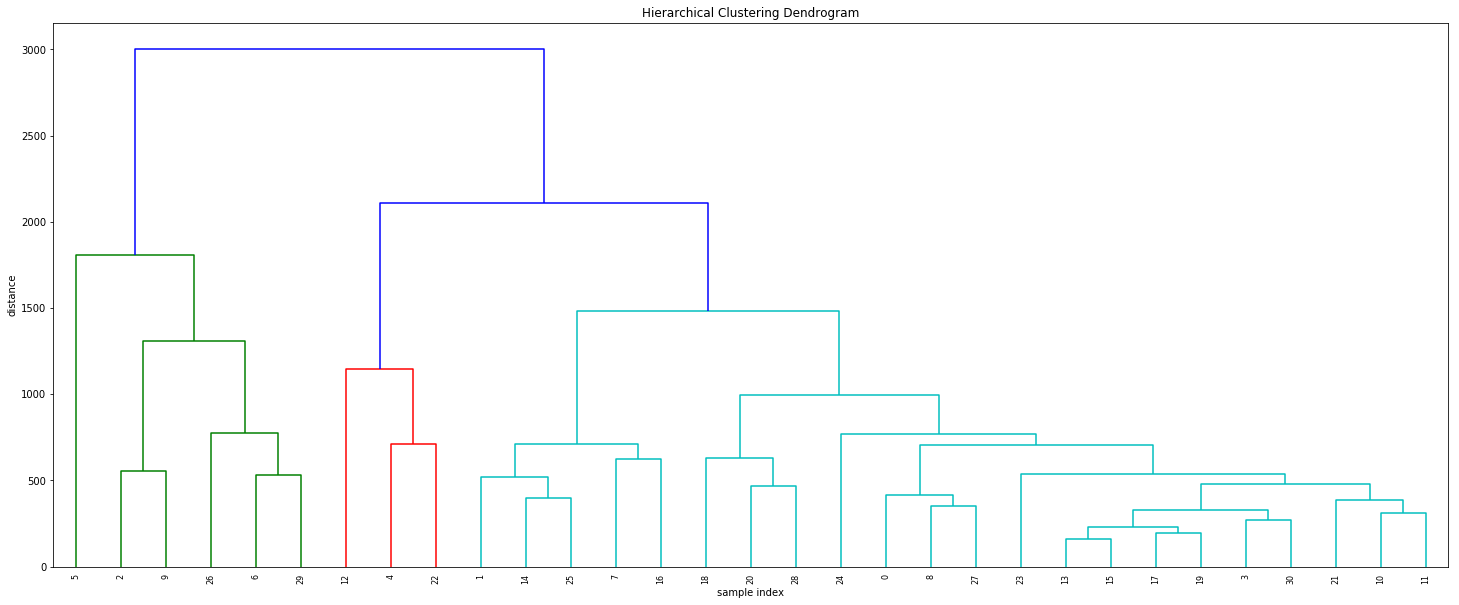

In [134]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## Spectral clustering(SC)

### Data preprocessing

In [5]:
## pick the ones with consecutive records
dfs_train = []
indexes = [0,1,2,4,6,12,13,14,16,17,19,22,23,24,28,29,30,31,33,34,35,37,38]
for i in indexes:
    dfs_train.append(dfs[i])

In [6]:
dfs_train[0]['pid'].values[:1]

array(['27700103'], dtype=object)

In [36]:
## Splite time windows for training
MAX_WIN_POINTS = 31 # the maximum datapoints in one window
MIN_WIN_POINTS = 20
def padding(bgs, max_len):
    #remove the 
    #make the array list same shapes
    len_bgs = len(bgs)
    if len_bgs < max_len:
        # padding with mean value
        value = int(np.sum(bgs)/len_bgs)
        paddings = [value for x in range(len_bgs, max_len)]
#         print('paddings', paddings)
        bgs = bgs + paddings 
#         print('bgs', bgs)
    return bgs
        

def split_windows(df, start_date, end_date, window_size, step, index_dict):
    len_df = len(df)
    if len(df['sgv'].unique()) <= 1:
        return []
    df.sort_index(ascending = True, inplace = True)
    splites = []
    dict_arrays = []
    discarded = 0
    for i in pd.date_range(start = start_date, end = end_date, freq=step):
#         print(i)
        win = df[i:i + pd.Timedelta(window_size)]
        if len(win)<MIN_WIN_POINTS or len(win)>MAX_WIN_POINTS:
            discarded += 1
            continue
        splite = list(win['sgv'].values) 
#         print('splite before padding', splite)
        splite = padding(splite, MAX_WIN_POINTS)
#         print('splite', splite)

#         print('length of splite after padding', len(splite))
        splites.append(splite)
                 
        dict_i = {}
        dict_i.update(pid = win['pid'].values[0])
        dict_i.update(check = i)
        dict_i.update(sgvs = splite)       
        dict_arrays.append(dict_i)
    print('skipped counts', discarded)
    print('splites.shape', np.array(splites).shape)
    index_dict = index_dict.append(dict_arrays, sort=False, ignore_index=True)
    return splites,index_dict

In [50]:
index_dict.iloc[12819]

pid                                               20216809
check                                  2018-01-23 02:30:00
sgvs     [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 5.0, 5.0,...
Name: 12819, dtype: object

In [87]:
index_dict['pid'].unique()

array(['27700103', '96254963', '57176789', '20396154', '00897741',
       '66836068', '66019205', '95851255', '97417885', '20216809',
       '47750728', '60844515', '37764532', '43589707', '14092221',
       '96805916', '95614431', '21946407', '37948668', '25692073',
       '99848889', '15634563', '80796147'], dtype=object)

## Old version SC

In [ ]:
path = '/Users/wang/data/OpenAPS/entry_dfs'
dfs=[]
for file in os.listdir(path):
    df = pickle.load(open(path+'/'+file, 'rb'))
    df.set_index('datetime', inplace=True)
    df = df.tz_convert(None)
    start_date = '2018-01-01'
    end_date = '2018-01-31'
    df_2018 = df[start_date:end_date]
    if df_2018.empty:
        continue
    print(df_2018.describe())
    print(df_2018.tail())
#     print(df.index)
#     df_2018 = pd.date_range('2018-01-01', '2019-01-01')

    dfs.append(df_2018)


In [ ]:
# (all)data preprocessing, 2.5 hours window + 75% overlap


path = '/Users/wang/data/OpenAPS/entry_dfs'
window_size = 30 # min
step = 6

#indexing the windows slices with pid and checkpoint time
index_dict = pd.DataFrame(columns=['pid', 'check', 'sgvs'])

dummy = []

for file in os.listdir(path):
    print(file)
    df = pickle.load(open(path+'/'+file, 'rb'))
    if df.empty:
        continue
    print('processing', np.asscalar(df['pid'][0:1]))
    print('missing value count', df['sgv'].isna().sum())
    df['sgv'].interpolate(inplace = True)
    splites, index_dict = split_windows(df, window_size, step, index_dict)
    print('len_splites', len(splites))
    print('indexes', index_dict.index.values)
    print('----------------')

    dummy.append(splites)
    
print('len = ', len(dummy))   


# train_dasta = np.concatenate(dummy, axis =0)

pickle.dump(train_data, open('/Users/wang/data/OpenAPS/cluster_train.pkl', 'wb'))

pickle.dump(index_dict, open('/Users/wang/data/OpenAPS/cluster_train_index.pkl', 'wb'))


In [45]:
train_data_10 = train_data[:100000]

In [47]:
train_data_10.shape

(100000, 30)

## Clustering visualization

In [73]:
X_pd = pickle.load(open('/Users/wang/data/OpenAPS/sgvs_train_2018-1-cluster-10.pkl', 'rb'))

In [74]:
grouped = X_pd.groupby(by='group')

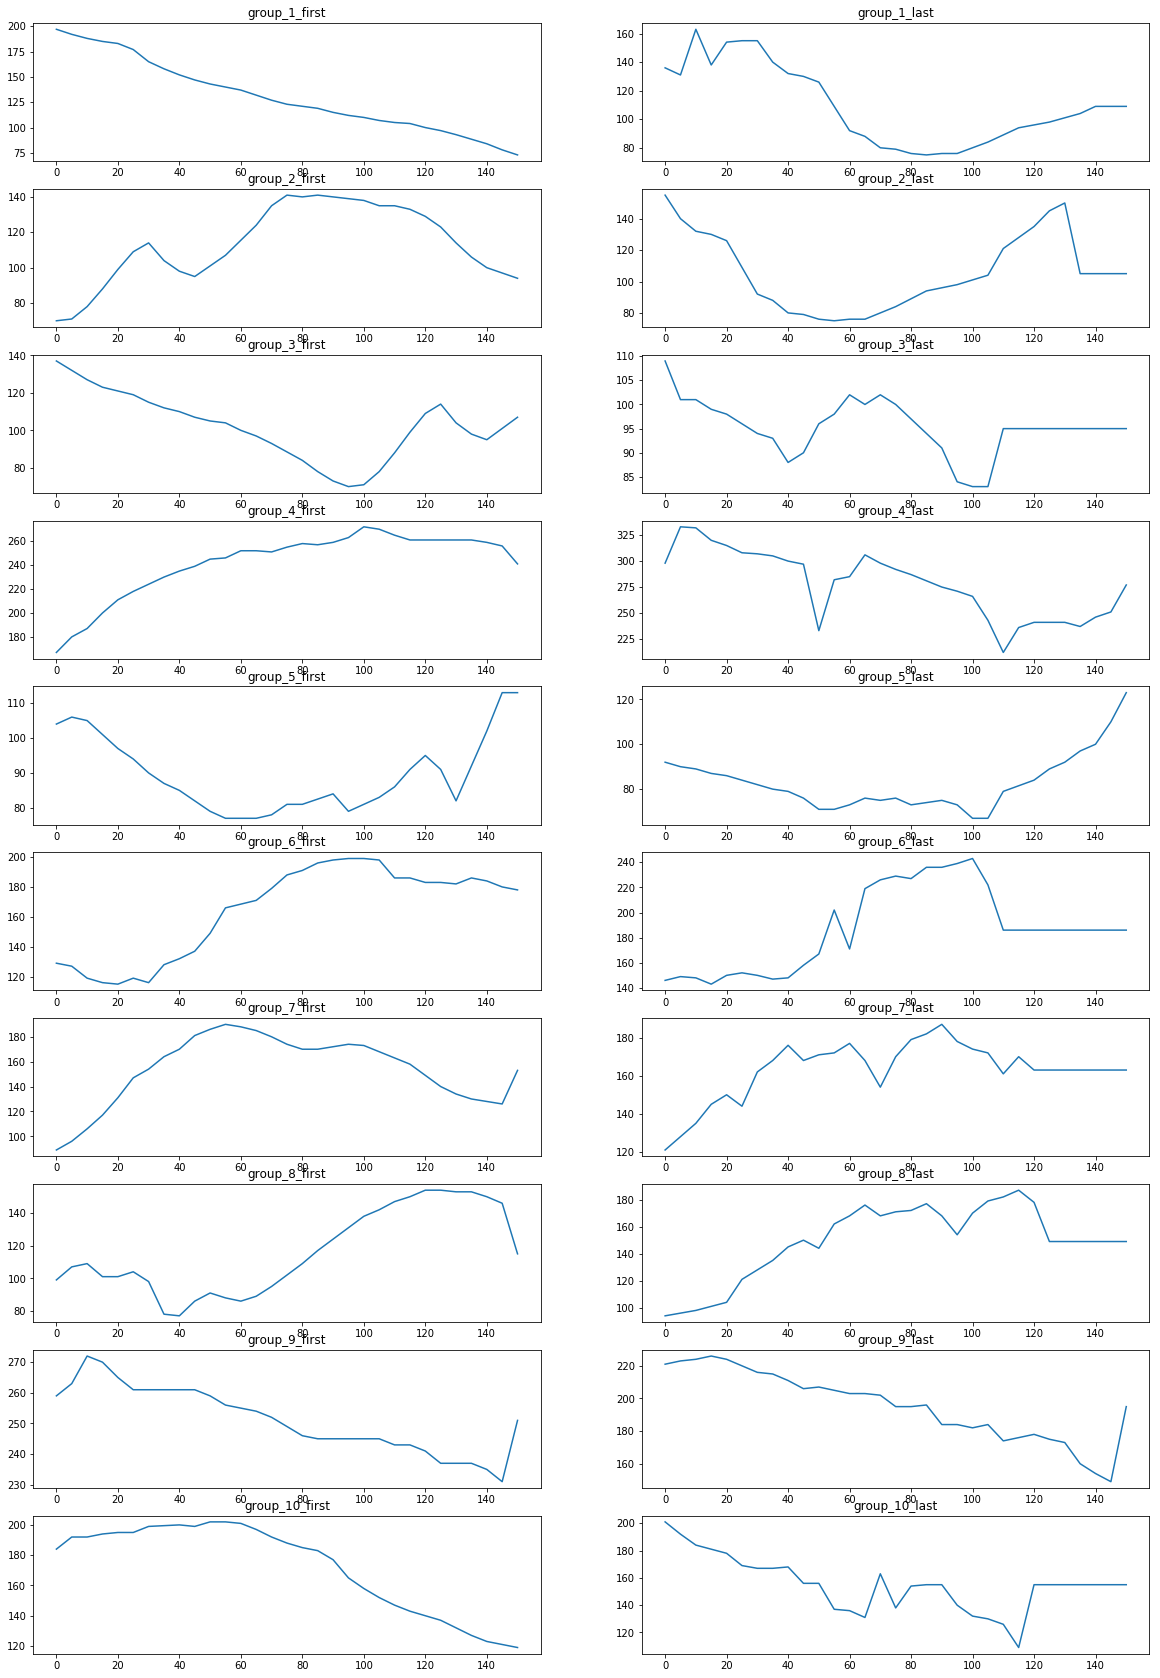

In [86]:
plt.figure(figsize=(20,30 ))
x = range(0, 151, 5)
first_grouped = grouped.first()
last_grouped = grouped.last()

j = 1
for i in range(1,11):
    plt.subplot(10,2,j)
    plt.plot(x, first_grouped.iloc[i-1].sgvs)
    plt.title('group_'+str(i)+'_first')
    j += 1
    plt.subplot(10,2,j)
    plt.plot(x, last_grouped.iloc[i-1].sgvs)
    plt.title('group_'+str(i)+'_last')
    j += 1

plt.show()